In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔹 Using device: {device}")

🔹 Using device: cuda


In [3]:
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root=r"D:\DLT", train=True, download=True, transform=transform)
subset_size = 5000
train_dataset, _ = torch.utils.data.random_split(train_dataset, [subset_size, len(train_dataset) - subset_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

Files already downloaded and verified


In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(100, 128, 4, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

In [13]:
import torch
from torch import nn

class Discriminator(nn.Module):
    def __init__(self, input_channels=3):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(input_channels, 64, 4, 2, 1),   # 32 -> 16
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1),             # 16 -> 8
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1),            # 8 -> 4
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.AdaptiveAvgPool2d((1, 1)),            # output (256, 1, 1)
            nn.Flatten(),
            nn.Linear(256, 1)                        # fixed — no mismatch
        )

    def forward(self, x):
        return self.model(x)


In [15]:
generator = Generator().to(device)
discriminator = Discriminator(input_channels=3).to(device)
criterion = nn.BCEWithLogitsLoss()
g_optimizer = optim.Adam(generator.parameters(), lr=1e-4)
d_optimizer = optim.Adam(discriminator.parameters(), lr=1e-4)


🔹 Starting DCGAN training...

Batch [100/157] | G Loss: 0.8718 | D Loss: 1.1312

Epoch [1/2] | Gen Loss: 0.8242 | Disc Loss: 1.1941 | Time: 4.33s


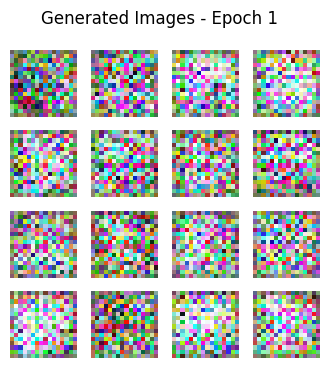

Batch [100/157] | G Loss: 1.2258 | D Loss: 0.7446

Epoch [2/2] | Gen Loss: 1.1586 | Disc Loss: 0.8271 | Time: 3.14s


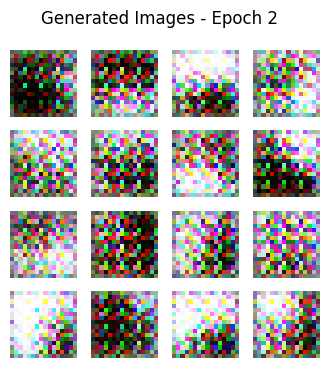

In [16]:
EPOCHS = 2
fixed_noise = torch.randn(16, 100, 1, 1, device=device)
gen_losses, disc_losses = [], []

print("\n🔹 Starting DCGAN training...\n")

for epoch in range(EPOCHS):
    start = time.time()
    g_loss_epoch, d_loss_epoch = 0, 0

    for i, (real_images, _) in enumerate(train_loader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

       
        noise = torch.randn(batch_size, 100, 1, 1, device=device)
        fake_images = generator(noise)

        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        d_optimizer.zero_grad()
        real_output = discriminator(real_images)
        fake_output = discriminator(fake_images.detach())
        d_loss = criterion(real_output, real_labels) + criterion(fake_output, fake_labels)
        d_loss.backward()
        d_optimizer.step()

       
        g_optimizer.zero_grad()
        fake_output = discriminator(fake_images)
        g_loss = criterion(fake_output, real_labels)
        g_loss.backward()
        g_optimizer.step()

        g_loss_epoch += g_loss.item()
        d_loss_epoch += d_loss.item()

        if (i + 1) % 100 == 0:
            print(f"Batch [{i+1}/{len(train_loader)}] | "
                  f"G Loss: {g_loss.item():.4f} | D Loss: {d_loss.item():.4f}")

    gen_losses.append(g_loss_epoch / len(train_loader))
    disc_losses.append(d_loss_epoch / len(train_loader))

    print(f"\nEpoch [{epoch+1}/{EPOCHS}] | "
          f"Gen Loss: {gen_losses[-1]:.4f} | Disc Loss: {disc_losses[-1]:.4f} | "
          f"Time: {time.time()-start:.2f}s")

    # Generate sample images
    generator.eval()
    with torch.no_grad():
        fake_images = generator(fixed_noise).detach().cpu()
    generator.train()

    grid = np.transpose(
        (fake_images * 0.5 + 0.5).numpy(), (0, 2, 3, 1)
    )

    fig = plt.figure(figsize=(4, 4))
    for j in range(16):
        plt.subplot(4, 4, j + 1)
        plt.imshow(grid[j])
        plt.axis("off")
    plt.suptitle(f"Generated Images - Epoch {epoch+1}")
    plt.show()


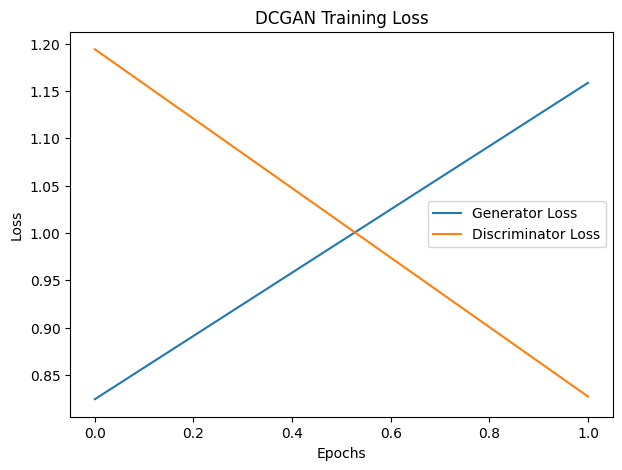

In [17]:
plt.figure(figsize=(7, 5))
plt.plot(gen_losses, label="Generator Loss")
plt.plot(disc_losses, label="Discriminator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("DCGAN Training Loss")
plt.show()